The strategy to predict the house prices consist in:

1. cleaning up the dataset by means of imputing the missing values in the numerical columns and encoding the categorical columns
2. training a GradientBoostingRegressor 
3. optimize the model with GridSearchCV
4. using the optimize model to predict the house prices values in the test dataset.

For a cleaner approach, I used a pipeline whenever possible, although encoding presents some known challenges when it comes to cross validation: this lead me to encode the categorical variables BEFORE the pipeline.

I do not normalize or scale the numerical data because diggin on the internet I found that this kind of manipulation really should not help (nor hurt) the model ( https://datascience.stackexchange.com/questions/16225/would-you-recommend-feature-normalization-when-using-boosting-trees ).

In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

I upload the dataset that will provide me with the test and training data.
I need to manipulate the columns before feeding them to the ML algorithm: specifically, I need to encode the categorical variables and find a way to compensate for the NaNs in the numerical variables.

In [3]:
train_i = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
print(train_i.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


The column 'MSSubClass' is numerical, but it is used to identify the type of dwelling involved in the sale. I believe it would better serve as a feature if it was a categorical variable to undergo encording. Therefore I cast it to string.

In [4]:
train_i['MSSubClass'] = train_i['MSSubClass'].astype(str)

I create a list of categorical and numerical variables, and eliminate the columns 'SalePrice' and 'Id' that I don't want to be features for obvious reasons.

In [5]:
numerical_cols = []
categorical_cols = []

for col in train_i.columns:
    if train_i[col].dtype == 'object':
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

numerical_cols.remove('SalePrice')
numerical_cols.remove('Id')

Choosing which variable to One Hot Encode and which to Label Encode is not straightforward, so I decided to first Label Encode all the categorical variables.

In [6]:
trial_df_le = pd.DataFrame()

le = LabelEncoder()
for col in categorical_cols:
    trial_df_le[col] = le.fit_transform(train_i[col].astype(str))

trial_df_le['SalePrice'] = train_i['SalePrice']

Once I re-add 'SalePrice' to the Label Encoded variabled dataframe, I can investigate the correlation between the label encoded categorical variables and the sale price of the house. If the program detects a correlation value higher than 0.4 or smaller than -0.4, then I deem the correlation significant, I consider that the corrisponding variable should be Label Encoded rather than One Hot Encoded and I store the name of the variable for future reference.

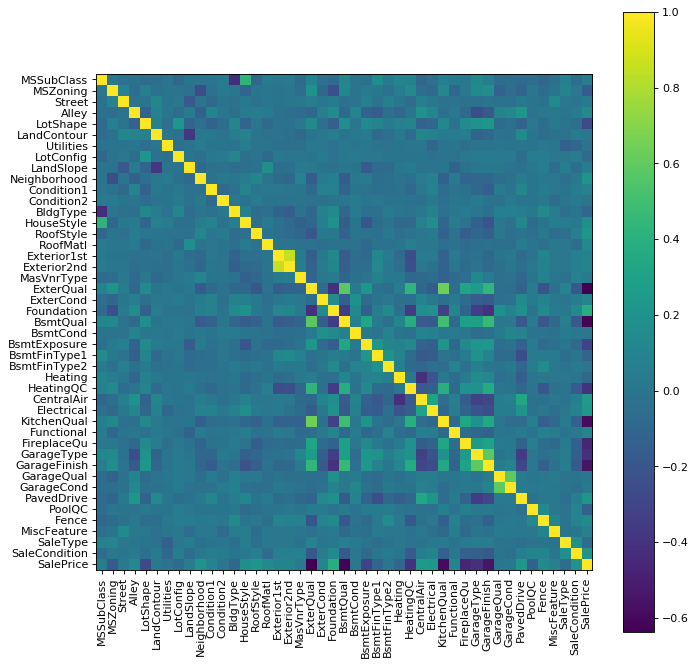

In [7]:
dfm_le = trial_df_le[[col for col in trial_df_le if trial_df_le[col].nunique() > 1]] 
corr_le = dfm_le.corr()
corr_le_keep = corr_le[abs(corr_le['SalePrice'])>0.4]
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
corrMat = plt.matshow(corr_le, fignum = 1)
plt.xticks(range(len(corr_le.columns)), corr_le.columns, rotation=90)
plt.yticks(range(len(corr_le.columns)), corr_le.columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corrMat)
plt.show()

I proceed by lLabel Encoding the columns I previously determined having a significant correlation with the sale price, and One Hot Encode the rest of the categorical variables.

In [8]:
cat_le = corr_le_keep.index.tolist()

cat_le.remove('SalePrice')
cat_ohe = list((Counter(categorical_cols)-Counter(cat_le)).elements())


for col in cat_le:
    train_i[col] = le.fit_transform(train_i[col].astype(str))
    
train_processed = pd.get_dummies(train_i,
                              columns=cat_ohe)

As usual, I split the dataset in train and set subsets, with the training set constituting the 80% of the overall dataset.

In [9]:
train_inter, test_inter = train_test_split(
    train_processed, test_size=0.2)

train, test = train_inter.align(test_inter, join='outer', axis=1)
X_train = train.drop(columns=['Id', 'SalePrice'])
X_test = test.drop(columns=['Id', 'SalePrice'])

y_train = train['SalePrice']
y_test = test['SalePrice']

I decided to implement the ML algorithm using pipelines. I had many troubles with the encoding part of the categorical variables, so I decided to encode the variables outside the pipeline.
The pipeline consists in:
1. preprocessing the numerical columns using the SimpleImputer, which as default substitutes the NaNs with the mean of the column.

In [19]:
numerical_transformer_NaN = SimpleImputer()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_NaN, numerical_cols)


    ], remainder='passthrough')

2. reduce the dimension of the dataset by using SelectKBest
3. train GradientBoostingRegressor as a classifier

In [20]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('reduce_dim', SelectKBest(mutual_info_classif)),
                            ('clf', LGBMRegressor(random_state=0))
                             ])

I inject the pipeline into the GridSearchCV algorithm that by default performs a 5-fold cross validation (this is the point where encoding the variables in a pipeline started giving issues, so I decided to encode them outside of it.

The best parameters found are available in a dict and then fed into the new pipeline to be used for the prediction. 
This is actually the code I ran, but it took me a few hours so I will just copy the dict results from the run in my local machine and use them in this notebook.

In [ ]:
parameters = [{
        'reduce_dim__k': [100, 200, 278],
        'clf__learning_rate': [1.0,0.3,0.1],
        'clf__max_depth': [6, 4, 2],
        'clf__num_leaves': [30, 60]}]



CV = GridSearchCV(pipeline, parameters, scoring = 'explained_variance', n_jobs=1)
CV.fit(X_train, y_train)

In [ ]:
best_params_dict = {'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__num_leaves': 30, 'reduce_dim__k': 278}
 #CV.best_params_
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('reduce_dim', SelectKBest(mutual_info_classif, k = best_params_dict["reduce_dim__k"])),
                            ('clf', LGBMRegressor(random_state=0, num_leaves = best_params_dict["clf__num_leaves"], learning_rate = best_params_dict["clf__learning_rate"], max_depth = best_params_dict["clf__max_depth"]

                                                              ))
                             ])




pipeline.fit(X_train, y_train)

At this point I upload the test dataset that does not have a 'SalePrice' column.

In [23]:
test_submission = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')

I encode the features exactly like I did before in the case of Label Encoding, while I use reindex in the case of One Hote Encoding because that allows me to keep consistency between the old dataset columns and this new (test) dataset columns.

In [24]:
dummy_submission = pd.get_dummies(test_submission,
                              columns=cat_ohe)


for col in cat_le:
    dummy_submission[col] = le.fit_transform(test_submission[col].astype(str))

    
dummy_submission=dummy_submission.reindex(columns = train_processed.columns, fill_value=0)

Reindexing reinstates the column 'SalePrice' (although it is a NaN column), in addition the test dataset has an 'Id' column as well: I therefore have to drop boh of them, otherwise my model will not be able to perform a prediction.

In [25]:
dummy_submission_to_pred = dummy_submission.drop(columns=['Id', 'SalePrice'])

preds = pipeline.predict(dummy_submission_to_pred)

Once I have the prediction in a list, I can combine them in a dataframe with the test dataset column 'Id': in that way I can produce a csv file that contains my prediction in a form that is suitable for the Kaggle submission.

In [26]:
df_submit = pd.DataFrame()
df_submit["Id"] = dummy_submission["Id"]

df_submit["SalePrice"]= preds
df_submit.to_csv('./best_model_submission.csv', index=False)

     Id      SalePrice
0  1461  125435.270728
1  1462  157014.162715
2  1463  173317.507853
3  1464  185208.180390
4  1465  198707.836727
